# Sequence Feasibility Analysis

Diagnose why 0 sequences are built, estimate potential counts under different settings, and relax constraints to produce a trainable set.

In [18]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch

# Paths
reddit_path = Path('year_reddit_data.csv')
yf_path = Path('year_yf_data.csv')

# Load
reddit_df = pd.read_csv(reddit_path)
yf_df = pd.read_csv(yf_path)

# Reddit: parse time and normalize
reddit = reddit_df.copy()
if 'post.created_utc' in reddit.columns and 'created_utc' not in reddit.columns:
    reddit = reddit.rename(columns={'post.created_utc':'created_utc'})
reddit['created_utc'] = pd.to_datetime(reddit['created_utc'], utc=True, errors='coerce')
reddit['date'] = reddit['created_utc'].dt.tz_convert('US/Eastern').dt.date
# Ensure ticker column and normalize to uppercase to match YF
if 'Ticker_id' in reddit.columns and 'ticker' not in reddit.columns:
    reddit['ticker'] = reddit['Ticker_id'].astype(str)
if 'ticker' in reddit.columns:
    reddit['ticker'] = reddit['ticker'].astype(str).str.upper()

# YF: parse multi-index headers (field, ticker)
yf_multi = pd.read_csv(yf_path, header=[0,1], index_col=0, skiprows=[2])
yf_multi.index.name = 'date'
yf_multi.index = pd.to_datetime(yf_multi.index, errors='coerce')

def _to_long(cat: str) -> pd.DataFrame:
    if cat not in yf_multi.columns.get_level_values(0):
        return pd.DataFrame(columns=['date','ticker',cat])
    dfc = yf_multi[cat]
    long_df = dfc.stack().reset_index()
    long_df.columns = ['date','ticker',cat]
    return long_df

close_long = _to_long('Close')
vol_long = _to_long('Volume')
yf_long = close_long.merge(vol_long, on=['date','ticker'], how='outer')
yf_long['date'] = pd.to_datetime(yf_long['date'], errors='coerce').dt.date
yf_long['ticker'] = yf_long['ticker'].astype(str).str.upper()
print(reddit.head())
print(yf_long.head())

   Unnamed: 0       id               created_utc ticker subreddit  \
0           0  1oyzy4v 2025-11-16 22:59:25+00:00   NVDA    stocks   
1           1  1owabf1 2025-11-13 19:23:30+00:00   NVDA    stocks   
2           2  1ow7lym 2025-11-13 17:43:31+00:00   NVDA    stocks   
3           3  1ovqca4 2025-11-13 03:17:50+00:00   NVDA    stocks   
4           4  1ovctdu 2025-11-12 18:15:41+00:00   NVDA    stocks   

                 author                                              title  \
0            Denver-Ski  Peter Thiel’s latest 13F shows a full exit fro...   
1        SecretComposer  Do you have any less discussed positions that ...   
2    Necessary_Fold5478  Nvidia CEO reportedly said China will lead the...   
3  Apprehensive_Two1528  USD to CNY hits lowest level YTD. Apple is gon...   
4           One_Rub7972  CRWV has plummeted; is now a good time to buy ...   

   score  upvote_ratio  num_comments query   stock                 created_dt  \
0   1478          0.93           24

In [19]:
print('Reddit columns:', list(reddit.columns))
print(reddit.head(3))

Reddit columns: ['Unnamed: 0', 'id', 'created_utc', 'ticker', 'subreddit', 'author', 'title', 'score', 'upvote_ratio', 'num_comments', 'query', 'stock', 'created_dt', 'days_ago', 'weeks_ago', 'date']
   Unnamed: 0       id               created_utc ticker subreddit  \
0           0  1oyzy4v 2025-11-16 22:59:25+00:00   NVDA    stocks   
1           1  1owabf1 2025-11-13 19:23:30+00:00   NVDA    stocks   
2           2  1ow7lym 2025-11-13 17:43:31+00:00   NVDA    stocks   

               author                                              title  \
0          Denver-Ski  Peter Thiel’s latest 13F shows a full exit fro...   
1      SecretComposer  Do you have any less discussed positions that ...   
2  Necessary_Fold5478  Nvidia CEO reportedly said China will lead the...   

   score  upvote_ratio  num_comments query   stock                 created_dt  \
0   1478          0.93           241  nvda  nvidia  2025-11-16 22:59:25+00:00   
1     73          0.96           144  nvda  nvidia  2025

In [20]:
# Daily coverage from reddit
# Ensure `date` dtype is datetime.date and ticker uppercase before grouping
reddit['date'] = pd.to_datetime(reddit['date']).dt.date
reddit['ticker'] = reddit['ticker'].astype(str).str.upper()
cover = (
    reddit.groupby(['ticker','date'])
    .agg(posts=('id','count'), score_sum=('score','sum'))
    .reset_index()
)
cover = cover.rename(columns={'score_sum':'ups_sum'})

# Merge with Close/Volume
yf_long['date'] = pd.to_datetime(yf_long['date']).dt.date
yf_long['ticker'] = yf_long['ticker'].astype(str).str.upper()
merged = (
    yf_long.merge(cover, on=['ticker','date'], how='left')
            .sort_values(['ticker','date'])
)
merged['posts'] = merged['posts'].fillna(0).astype(int)
merged['ups_sum'] = merged['ups_sum'].fillna(0)
print(merged.head())

          date ticker       Close      Volume  posts  ups_sum
0   2024-11-18   AAPL  226.993378  44633700.0      1    798.0
6   2024-11-19   AAPL  227.252197  36211800.0      0      0.0
12  2024-11-20   AAPL  227.968948  35169600.0      1     11.0
18  2024-11-21   AAPL  227.491119  42108300.0      2  15535.0
24  2024-11-22   AAPL  228.835037  38168300.0      2    676.0


  ticker  reddit_days  have_close    min_date    max_date  nan_close  nan_rate
0   AAPL          366         366  2024-11-18  2025-11-18          0       0.0
1   AMZN          366         366  2024-11-18  2025-11-18          0       0.0
2  GOOGL          366         366  2024-11-18  2025-11-18          0       0.0
3   MSFT          366         366  2024-11-18  2025-11-18          0       0.0
4   NVDA          366         366  2024-11-18  2025-11-18          0       0.0
5   TSLA          366         366  2024-11-18  2025-11-18          0       0.0


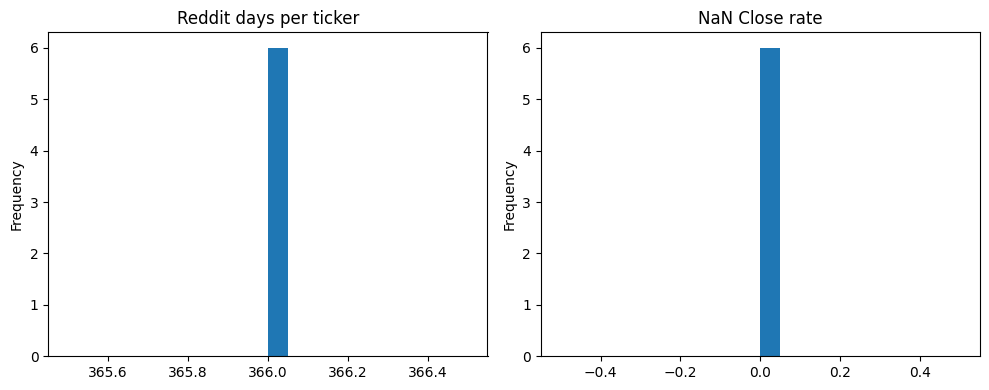

In [21]:
# Per-ticker coverage stats
stats = (
    merged.groupby('ticker')
    .agg(
        reddit_days=('date','nunique'),
        have_close=('Close', lambda s: s.notna().sum()),
        min_date=('date','min'),
        max_date=('date','max'),
        nan_close=('Close', lambda s: s.isna().sum()),
    )
    .reset_index()
)
stats['nan_rate'] = stats['nan_close'] / (stats['reddit_days'].replace(0, np.nan))
print(stats.sort_values('reddit_days', ascending=False).head(10))

# Histograms
fig, ax = plt.subplots(1,2, figsize=(10,4))
stats['reddit_days'].plot(kind='hist', bins=20, ax=ax[0], title='Reddit days per ticker')
stats['nan_rate'].fillna(0).plot(kind='hist', bins=20, ax=ax[1], title='NaN Close rate')
plt.tight_layout()
plt.show()

In [22]:
# Baseline sequence builder
from pandas.tseries.offsets import BDay

def build_windows(df, seq_len=5, horizon=5, require_all_posts=False):
    """
    df: columns [ticker, date, Close, Volume, posts, ups_sum]
    Returns dict[ticker] -> list of (start_date, end_date, label_date)
    Conditions:
      - have Close & Volume for all days in the window
      - optionally require reddit posts on all days
      - label by comparing Close at label_date vs last day in window
    """
    out = {}
    for tkr, g in df.groupby('ticker'):
        g = g.sort_values('date').copy()
        # ensure business day index
        bidx = pd.date_range(g['date'].min(), g['date'].max(), freq='B')
        g = g.set_index('date').reindex(bidx).rename_axis('date').reset_index()
        g['ticker'] = tkr
        # carry reddit counts as 0 when missing; price NaNs remain
        g['posts'] = g['posts'].fillna(0)
        g['ups_sum'] = g['ups_sum'].fillna(0)
        wins = []
        for i in range(len(g) - seq_len - horizon + 1):
            win = g.iloc[i:i+seq_len]
            label_day = g.iloc[i+seq_len+horizon-1]
            # price availability
            if win['Close'].isna().any() or win['Volume'].isna().any():
                continue
            if pd.isna(label_day['Close']):
                continue
            if require_all_posts and (win['posts'] <= 0).any():
                continue
            start = win['date'].iloc[0]
            end = win['date'].iloc[-1]
            label_date = label_day['date']
            wins.append((start, end, label_date))
        out[tkr] = wins
    return out

base = build_windows(merged, seq_len=5, horizon=5, require_all_posts=False)
counts = {k: len(v) for k,v in base.items()}
print('Baseline windows per ticker (seq=5,h=5):')
print({k:v for k,v in counts.items() if v>0})
print('Total windows:', sum(counts.values()))

Baseline windows per ticker (seq=5,h=5):
{'AAPL': 253, 'AMZN': 253, 'GOOGL': 253, 'MSFT': 253, 'NVDA': 253, 'TSLA': 253}
Total windows: 1518


In [23]:
# Parameter sweep
from itertools import product

def reindex_prices(df, ffill=False):
    out = []
    for tkr, g in df.groupby('ticker'):
        g = g.sort_values('date').copy()
        bidx = pd.date_range(g['date'].min(), g['date'].max(), freq='B')
        g = g.set_index('date').reindex(bidx).rename_axis('date')
        if ffill:
            g[['Close','Volume']] = g[['Close','Volume']].ffill()
        g[['posts','ups_sum']] = g[['posts','ups_sum']].fillna(0)
        g['ticker'] = tkr
        out.append(g.reset_index())
    return pd.concat(out, ignore_index=True)

merged_ffill = reindex_prices(merged, ffill=True)

configs = [(s,h) for s in [3,4,5,7,10] for h in [2,3,5]]
results = []
for (s,h) in configs:
    base_counts = {k: len(v) for k,v in build_windows(merged, s, h).items()}
    ffill_counts = {k: len(v) for k,v in build_windows(merged_ffill, s, h).items()}
    results.append({
        'seq_len': s,
        'horizon': h,
        'total_base': sum(base_counts.values()),
        'total_ffill': sum(ffill_counts.values())
    })

res_df = pd.DataFrame(results).sort_values(['total_ffill','total_base','seq_len','horizon'], ascending=[False, False, True, True])
print(res_df)

    seq_len  horizon  total_base  total_ffill
0         3        2        1548         1548
1         3        3        1542         1542
3         4        2        1542         1542
4         4        3        1536         1536
6         5        2        1536         1536
2         3        5        1530         1530
7         5        3        1530         1530
5         4        5        1524         1524
9         7        2        1524         1524
8         5        5        1518         1518
10        7        3        1518         1518
11        7        5        1506         1506
12       10        2        1506         1506
13       10        3        1500         1500
14       10        5        1488         1488


In [24]:
# Choose a config and materialize sequences
best = res_df.iloc[0]
print('Chosen config:', best.to_dict())
use_ffill = True
source = merged_ffill if use_ffill else merged

wins = build_windows(source, int(best['seq_len']), int(best['horizon']))

# Build arrays (toy features: [Close, Volume, posts, ups_sum])
seqs = []
lengths = []
for tkr, lst in wins.items():
    g = source[source['ticker']==tkr].set_index('date')
    for (start, end, label_date) in lst[:2]:  # take up to 2 per ticker for a quick check
        window = g.loc[start:end]
        feats = window[['Close','Volume','posts','ups_sum']].to_numpy(dtype=float)
        seqs.append(torch.tensor(feats, dtype=torch.float32))
        lengths.append(len(window))

if len(seqs)==0:
    print('No sequences even after sweep—inspect coverage above.')
else:
    from dataset import collate_weekly
    items = [{"x": s, "length": l} for s,l in zip(seqs,lengths)]
    batch = collate_weekly(items)
    from model import LSTMClassifier
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMClassifier(input_dim=4).to(device)
    outputs = model(batch['x'].to(device), batch['lengths'])
    print('Batch shapes:', batch['x'].shape,
          '-> logits:', outputs['direction_logit'].shape,
          'magnitude:', outputs['magnitude'].shape,
          'conf:', outputs['confidence'].shape)

Chosen config: {'seq_len': 3, 'horizon': 2, 'total_base': 1548, 'total_ffill': 1548}
Batch shapes: torch.Size([12, 3, 4]) -> logits: torch.Size([12, 1]) magnitude: torch.Size([12, 1]) conf: torch.Size([12, 1])


Total windows: 1548
Windows with at least one Reddit post EVERY day: 674 (43.5%)
Windows with at least one Reddit post on ANY day: 1395 (90.1%)


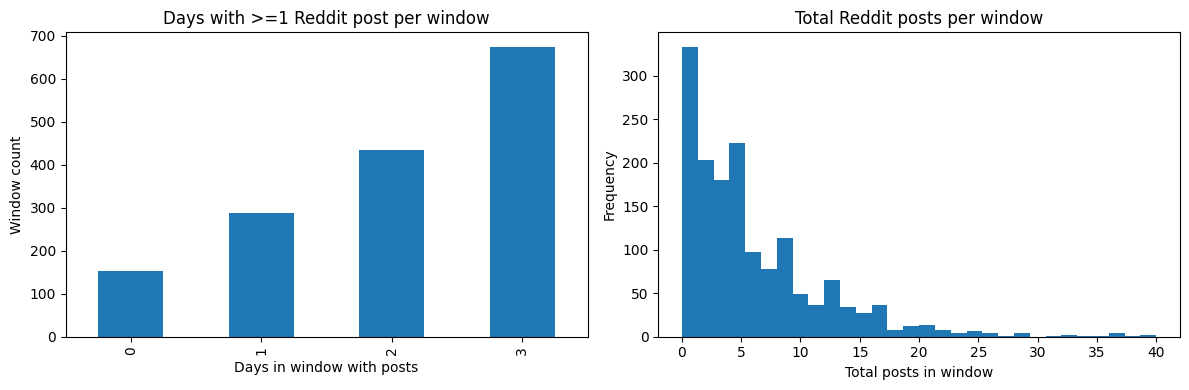

In [25]:
# Post coverage within windows: all-days vs any-day + distribution
# Make this cell self-contained so it runs after kernel restarts.

# 1) Ensure merged/source exists
if 'source' not in globals():
    if 'merged' not in globals():
        # Build merged from reddit & yf_long if needed
        if 'reddit' in globals() and 'yf_long' in globals():
            cover = (
                reddit.groupby(['ticker','date'])
                      .agg(posts=('id','count'), score_sum=('score','sum'))
                      .reset_index()
            ).rename(columns={'score_sum':'ups_sum'})
            merged = (
                yf_long.merge(cover, on=['ticker','date'], how='left')
                      .sort_values(['ticker','date'])
            )
            merged['posts'] = merged['posts'].fillna(0).astype(int)
            merged['ups_sum'] = merged['ups_sum'].fillna(0)
        else:
            raise RuntimeError('Missing reddit/yf_long or merged. Re-run earlier cells.')
    source = merged

# 2) Ensure build_windows exists
if 'build_windows' not in globals():
    from pandas.tseries.offsets import BDay
    def build_windows(df, seq_len=5, horizon=5, require_all_posts=False):
        out = {}
        for tkr, g in df.groupby('ticker'):
            g = g.sort_values('date').copy()
            bidx = pd.date_range(g['date'].min(), g['date'].max(), freq='B')
            g = g.set_index('date').reindex(bidx).rename_axis('date').reset_index()
            g['ticker'] = tkr
            g['posts'] = g['posts'].fillna(0)
            g['ups_sum'] = g['ups_sum'].fillna(0)
            wins = []
            for i in range(len(g) - seq_len - horizon + 1):
                win = g.iloc[i:i+seq_len]
                label_day = g.iloc[i+seq_len+horizon-1]
                if win['Close'].isna().any() or win['Volume'].isna().any():
                    continue
                if pd.isna(label_day['Close']):
                    continue
                if require_all_posts and (win['posts'] <= 0).any():
                    continue
                wins.append((win['date'].iloc[0], win['date'].iloc[-1], label_day['date']))
            out[tkr] = wins
        return out

# 3) Ensure wins exists
if 'wins' not in globals():
    if 'best' in globals():
        s, h = int(best['seq_len']), int(best['horizon'])
    else:
        s, h = 3, 2  # good default from sweep
    wins = build_windows(source, seq_len=s, horizon=h)

# 4) Compute coverage metrics and visualize
if sum(len(v) for v in wins.values()) == 0:
    print('No windows available. Re-run previous cells to build `wins`.')
else:
    # Attempt to infer seq_len from windows
    sample_tkr = next((k for k,v in wins.items() if len(v)>0), None)
    if sample_tkr is None:
        seq_len = None
    else:
        g = source[source['ticker']==sample_tkr].set_index('date')
        start, end, _ = wins[sample_tkr][0]
        seq_len = len(g.loc[start:end])

    rows = []
    for tkr, lst in wins.items():
        g = source[source['ticker']==tkr].set_index('date')
        for (start, end, label_date) in lst:
            window = g.loc[start:end]
            posts = window['posts'].fillna(0)
            days_with_post = int((posts > 0).sum())
            rows.append({
                'ticker': tkr,
                'start': start,
                'end': end,
                'days': len(window),
                'days_with_post': days_with_post,
                'has_all_days': days_with_post == len(window),
                'has_any_day': days_with_post > 0,
                'total_posts': float(posts.sum()),
            })
    win_posts = pd.DataFrame(rows)

    total_windows = len(win_posts)
    all_days_count = int(win_posts['has_all_days'].sum())
    any_day_count = int(win_posts['has_any_day'].sum())

    print(f'Total windows: {total_windows}')
    print(f'Windows with at least one Reddit post EVERY day: {all_days_count} ({all_days_count/total_windows:.1%})')
    print(f'Windows with at least one Reddit post on ANY day: {any_day_count} ({any_day_count/total_windows:.1%})')

    k_max = seq_len or int(win_posts['days'].max())
    dist = win_posts['days_with_post'].value_counts().reindex(range(0, k_max+1), fill_value=0)

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    dist.plot(kind='bar', ax=ax[0])
    ax[0].set_title('Days with >=1 Reddit post per window')
    ax[0].set_xlabel('Days in window with posts')
    ax[0].set_ylabel('Window count')

    win_posts['total_posts'].plot(kind='hist', bins=30, ax=ax[1])
    ax[1].set_title('Total Reddit posts per window')
    ax[1].set_xlabel('Total posts in window')
    plt.tight_layout()
    plt.show()